In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import requests
import json
import matplotlib.pyplot as plt
import math
import scipy.stats as st

from dateutil import parser
import matplotlib.dates as mdates

In [41]:
def create_tuple(response):
    response_data = response.json()
    response_datum = response_data[0]
    response_target = response_datum['target']
    response_datapoints = response_datum['datapoints']
    tuple_array = [tuple(x) for x in response_datapoints]
    npa = np.array(tuple_array, dtype=[
        ('value', np.double), ('ts', 'datetime64[ms]')])
    return npa

In [42]:
"""
Returns an array of tuples where tuple[0] is the metric, and tuple[1] is the time
of measurement

Target: a WebCTRL point name in the form of a string
Example: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log"

Server: a string representing the WebCTRL server our point exists in
Example: "biotech_main"

Start: the start time we wish to be querying data about (in string format)
Example: "2021-12-31T11:00Z"

End: The end time we wish to be querying data about
Example: "2022-12-31T11:00Z"
"""
def fume_query(target,server, start,end):
    url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
    data = {
        "range": {
            "from": start,
            "to": end,
        },
        "targets": [
            {
                "payload": {
                    "schema": server,
                },
                "target": target
            }
        ],

    }
    request = requests.post(url, json=data)
    #print(request)
    #print(request.json())
    return create_tuple(request)

# fume_query(target="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", server="biotech_main", start="2021-12-25T00:00:00.000", end="2021-12-25T00:00:00.000")
# fume_query(target="#biotech_weather/temperature_tn", server="biotech_main", star


In [43]:
def query_to_list(point, server, start, end):
    master = fume_query(point, server, start, end)

    list = pd.Series(data=[i[0] for i in master], index=[i[1] for i in master])
    #print("\n", point, "\n", list)

    list = list[~list.index.duplicated()]
    #print("\n", point, " new\n", list)

    return list

In [44]:
# Arguments: Sash Point, Occ Point, Server Name, Start Time, End Time
# Returns: Total time that hood sash was open when room is unoccupied, aggregated by hour


def total_time_sash_open_unoccupied(sash_point, occ_point, server, start, end):
    sash_list = query_to_list(sash_point, server, start, end)
    occ_list = query_to_list(occ_point, server, start, end)

    df = pd.concat([sash_list, occ_list], axis=1)
    df.columns = ["sash", "occ"]
    #display(df)

    time_interval = df.index[1].minute - df.index[0].minute

    # Figure out closed sash position
    # display(df["sash"].value_counts())

    # from running the above on a large time difference, 1.2 inches is the most common smallest value
    df["time_open_mins"] = np.where((df["sash"] > 1.2) & (df["occ"] == 0), time_interval, 0)

    df = df.dropna()
    #display(df)

    df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()

    return df["time_open_mins"]

total_time_sash_open_unoccupied(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                server="biotech_main",
                                start = str(datetime(2021, 11, 17, 1)),
                                end = str(datetime(2021, 11, 17, 2)))

2021-11-17 06:00:00     0
2021-11-17 07:00:00    10
2021-11-17 08:00:00    50
2021-11-17 09:00:00     0
2021-11-17 10:00:00    30
2021-11-17 11:00:00    40
2021-11-17 12:00:00    15
2021-11-17 13:00:00    40
2021-11-17 14:00:00    10
2021-11-17 15:00:00     0
2021-11-17 16:00:00     0
2021-11-17 17:00:00     0
2021-11-17 18:00:00     0
2021-11-17 19:00:00     0
2021-11-17 20:00:00     0
2021-11-17 21:00:00     0
2021-11-17 22:00:00     0
2021-11-17 23:00:00     0
2021-11-18 00:00:00     0
2021-11-18 01:00:00     0
2021-11-18 02:00:00     0
2021-11-18 03:00:00    55
2021-11-18 04:00:00    25
2021-11-18 05:00:00    30
Freq: 60T, Name: time_open_mins, dtype: int32

In [45]:
# Arguments: CFM Point, Sash Point, Occ Point, Internal Temp Point, External Temp Point, Server Name, Start Time, End Time
# Returns: Total energy from hume hood, aggregated by hour.  Can be adapted later on to only show energy when unoccupied

# A switch in the energy calculations that allows us to avoid issues between times of years where it is hotter/colder outside.
def coldorhot(cfm, external, internal, time_interval):
    if external<=internal:
        #sensible heating equation
        return 1.08 * cfm * (internal - external) / (60 / time_interval)
    if external>internal:
        #enthalpy of air
        return 0.24 * cfm /13.333 * 60 * (external - internal) / (60 / time_interval)

def total_energy(cfm_point, sash_point, occ_point, internal_temp_point, external_temp_point, server, start, end):
    #external_temp_master = outside_temp(start,end)
    cfm_list = query_to_list(cfm_point, server, start, end)
    sash_list = query_to_list(sash_point, server, start, end)
    occ_list = query_to_list(occ_point, server, start, end)
    internal_temp_list = query_to_list(internal_temp_point, server, start, end)
    external_temp_list = query_to_list(external_temp_point, server, start, end)

    df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
    df.columns = ["cfm", "sash", "occ", "internal_temp", "external_temp"]
    #display(df)

    df["external_temp"] = df["external_temp"].interpolate()
    #display(df)

    time_interval = df.index[1].minute - df.index[0].minute

    df['BTU'] = df.apply(lambda df: coldorhot(df['cfm'], df['external_temp'], df['internal_temp'], time_interval=time_interval), axis=1)
    #print("\nFinal Data Frame: ")
    #display(df)

    df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
    #display(df)

    return df["BTU"]

total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
             sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
             occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
             internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
             external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
             server = "biotech_main",
             start=str(datetime(2021, 11,17)),
             end=str(datetime(2021, 11, 18)))

2021-11-17 06:00:00    8897.68611
2021-11-17 07:00:00    8894.77461
2021-11-17 08:00:00    8835.30861
2021-11-17 09:00:00    8783.13078
2021-11-17 10:00:00    8987.19759
2021-11-17 11:00:00    8544.53253
2021-11-17 12:00:00    8110.01574
2021-11-17 13:00:00    8001.60912
2021-11-17 14:00:00    7649.42160
2021-11-17 15:00:00    7317.14085
2021-11-17 16:00:00    7134.71613
2021-11-17 17:00:00    6813.28503
2021-11-17 18:00:00    6341.22387
2021-11-17 19:00:00    6029.75880
2021-11-17 20:00:00    5692.98126
2021-11-17 21:00:00    7604.98143
2021-11-17 22:00:00    7453.21290
2021-11-17 23:00:00    7449.60969
2021-11-18 00:00:00    7380.94521
2021-11-18 01:00:00    7247.46801
2021-11-18 02:00:00    5845.40184
2021-11-18 03:00:00    5097.14043
2021-11-18 04:00:00    5082.45864
2021-11-18 05:00:00    5084.66550
2021-11-18 06:00:00    4933.91175
2021-11-18 07:00:00    4769.72898
2021-11-18 08:00:00    4646.37774
2021-11-18 09:00:00    4172.63094
2021-11-18 10:00:00    3894.46179
2021-11-18 11:

In [46]:
url = 'https://github.com/thereidfleish/fume-hood-dashboard/blob/Robbie/report1678804296452.csv?raw=true'
pointnames = pd.read_csv(url)
pointnames.head()

,C1,Room,Pointname,Acronym,Point
0,Point List,NaN,NaN,NaN,NaN
1,Location:,Cornell University / Biotech Server / Biotech,NaN,NaN,NaN
2,report_progress_step(),NaN,NaN,NaN,NaN
3,report_progress_step(),NaN,NaN,NaN,NaN
4,report_progress_step(),NaN,NaN,NaN,NaN


In [47]:
#We want to collect the following:
#Air Flow Point, e.g: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log", HOOD FLOW

#Sash Opening Point, e.g: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", HOOD SASH POS

#Occupancy Point, e.g: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend", OCC SENSOR

#Internal Temperature Point, e.g: "#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log", ZONE TEMP

import re
"""
The goal of this function is to output an organized collection of point names corresponding to specific fume hoods throughout the Biotechnology building. It is unclear the best path forward at the moment, however, we will try to start small and then expand upwards. There will probably be a lot of edge cases to handle, but we will see. Using regular expressions seems to have helped quite a bit.
"""


def csv_parser(df):
    #df['name_match'] = df['first_name'].apply(lambda x: 'Match' if x == 'Bill' else 'Mismatch')
    #print(True and df["Point"].str.contains("_control"))
    hood_flows = np.array(df[df["Pointname"]== "HOOD FLOW" ]["Point"])
    sash_pos = np.array(df[df["Pointname"]== "HOOD SASH POS"]["Point"])
    occ_sens = df[df["Pointname"]== "OCC SENSOR"]["Point"]
    occ_sens = [i for i in occ_sens if re.search("lab_[A-Za-z]*[0-9]+[A-Za-z]*_control",i)]
    zone_temps = df[df["Pointname"]== "ZONE TEMP"]["Point"]
    zone_temps = [i for i in zone_temps if re.search("lab_[A-Za-z]*[0-9]+[A-Za-z]*_control/zonetemp",i)]
    ##biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log
    zone_temps = [i.split("/")[:4] for i in zone_temps]
    zone_temps = ['/'.join(i) for i in zone_temps]
    zone_temps = [i + "/zone/zone_temp/trend_log" for i in zone_temps]

    vals= {"Hood":hood_flows, "Sash":sash_pos}
    odf = pd.DataFrame(data = vals)
    #display(ndf)
    # print(len(hood_flows))
    # print(len(sash_pos))
    # print(len(occ_sens))
    # print(len(zone_temps))

    ovals= {"Occupancy":occ_sens, "Internal Temp":zone_temps}
    ndf = pd.DataFrame(data = ovals)

    return [ndf,odf]
csv_parser(pointnames)[0]



,Occupancy,Internal Temp
0,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...
1,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
2,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
3,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
4,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
...,...,...
65,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
66,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
67,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
68,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...


In [48]:
csv_parser(pointnames)[1]


,Hood,Sash
0,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...
1,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
2,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
3,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
4,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
...,...,...
61,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
62,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
63,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
64,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...


In [49]:
#Notice how the dataframes are not equal sizes; this is because certain labs are missing hood and sash points
#By looking at an excel file I found the following:
#Lab 147, Lab 217, Lab 218, Lab 427 are all missing hood and sash points
#We will remove these from the dataset

dfs = csv_parser(pointnames)
occ_temp = dfs[0]
hood_sash = dfs[1]

occ_temp = occ_temp.drop([3,9,11,58])
occ_temp = occ_temp.reset_index()
occ_temp = occ_temp.drop(["index"],axis=1)
occ_temp

,Occupancy,Internal Temp
0,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...
1,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
2,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
3,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
4,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
...,...,...
61,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
62,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
63,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
64,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...


In [50]:
#Now we can just combine the dataframes together and we can begin working on a hierarchical structure

combined = hood_sash.join(occ_temp)
display(combined)

,Hood,Sash,Occupancy,Internal Temp
0,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...
1,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
2,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
3,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
4,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...
...,...,...,...,...
61,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
62,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
63,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...
64,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...


In [51]:
def get_floor(text):
    blocks = text.split("/")
    floor_block = blocks[1]
    floor = floor_block.split("_")[1]
    return floor

combined['Floor'] = [get_floor(i) for i in combined["Hood"]]
#combined

def get_lab(text):
    blocks = text.split("/")
    lab_block = blocks[3]
    lab = lab_block.split("_")[1]
    return lab

combined["Lab"] = [get_lab(i) for i in combined["Hood"]]
combined

,Hood,Sash,Occupancy,Internal Temp,Floor,Lab
0,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,ground,g54
1,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,1st,141
2,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,1st,143
3,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,1st,147b
4,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,1st,153
...,...,...,...,...,...,...
61,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,4th,445b
62,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,4th,453
63,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,4th,453b
64,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,4th,457


In [52]:
#Rearranging the column orders :)


combined["External Temp"] = "#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat"
combined["Server"] = "biotech_main"
cols = ["Lab","Floor","Server", "Hood","Sash","Occupancy","Internal Temp", "External Temp"]
combined = combined[cols]
#combined.to_csv('C:\\Users\\Rob\\Documents\\GitHub\\fume-hood-dashboard\\pointnames.csv')
combined

,Lab,Floor,Server,Hood,Sash,Occupancy,Internal Temp,External Temp
0,g54,ground,biotech_main,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/biotech_ground_floor/ground_floor_fum...,#biotech/ground_flr_mech/building_hydronic_hea...
1,141,1st,biotech_main,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/ground_flr_mech/building_hydronic_hea...
2,143,1st,biotech_main,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/ground_flr_mech/building_hydronic_hea...
3,147b,1st,biotech_main,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/ground_flr_mech/building_hydronic_hea...
4,153,1st,biotech_main,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/biotech_1st_floor/first_floor_fume_ho...,#biotech/ground_flr_mech/building_hydronic_hea...
...,...,...,...,...,...,...,...,...
61,445b,4th,biotech_main,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/ground_flr_mech/building_hydronic_hea...
62,453,4th,biotech_main,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/ground_flr_mech/building_hydronic_hea...
63,453b,4th,biotech_main,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/ground_flr_mech/building_hydronic_hea...
64,457,4th,biotech_main,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/biotech_4th_floor/fourth_floor_fume_h...,#biotech/ground_flr_mech/building_hydronic_hea...


In [53]:
def find_greatest_energy_usage(df,startdate,enddate):
    energy_list = []
    lab_list = []
    for i in range(len(df["Hood"])):
        if i!= 42:
            energy = total_energy(cfm_point=df["Hood"][i],
                                 sash_point=df["Sash"][i],
                                 occ_point=df["Occupancy"][i],
                                 internal_temp_point=df["Internal Temp"][i],
                                 external_temp_point=df["External Temp"][i],
                                 server = df["Server"][i],
                                 start= startdate,
                                 end=enddate).sum()
            energy_list.append(energy)
            lab_list.append(df["Lab"][i])
    ndict = {"Labs":lab_list, "Energy":energy_list}
    df = pd.DataFrame(ndict)
    return df.sort_values("Energy",ascending=False)

ndf = find_greatest_energy_usage(combined,str(datetime(2022, 12,1)),str(datetime(2022, 12, 30)))
display(ndf)



<ipython-input-43-1b326c0a8f08>:4: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,Labs,Energy
45,403,9.295059e+06
13,233,9.003410e+06
34,327,8.579809e+06
42,360b,8.477475e+06
11,227,8.427447e+06
...,...,...
19,257,6.002709e+06
2,143,5.391770e+06
0,g54,3.898575e+06
41,345b,0.000000e+00


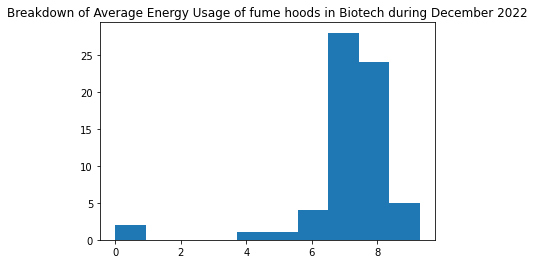

In [54]:
ndf["Standardized"] = ndf["Energy"]/1000000
plt.hist(ndf["Standardized"])
plt.title("Breakdown of Average Energy Usage of fume hoods in Biotech during December 2022")
plt.show()

In [55]:
"""
Goal Overall: Average Price/Day for a fume hood.

1. We need to calculate an average BTUH/day for each fume hood, over the specified time interval.
2. Look up a conversion factor from BTUH to electricity KWH. Average KWH/day
3. Multiply by some conversion factor to get an estimate of price.
4. If we want total price we can now just multiply by number of days that we specified.

Note: Average price is better because now we can extrapolate into the future to esimate how much a fume hood would cost over several years.
"""

#Test on One Fume Hood

#fumehood = combined.iloc[0].tolist()

start = str(datetime(2022, 12,1))
end = str(datetime(2022, 12,31))
i = 0
energy = total_energy(cfm_point=combined["Hood"][i],
                      sash_point=combined["Sash"][i],
                      occ_point=combined["Occupancy"][i],
                      internal_temp_point=combined["Internal Temp"][i],
                      external_temp_point=combined["External Temp"][i],
                      server = combined["Server"][i],
                      start= start,
                      end=end)
energy



2022-12-01 06:00:00    4431.19086
2022-12-01 07:00:00    4538.87469
2022-12-01 08:00:00    4643.03799
2022-12-01 09:00:00    4687.11144
2022-12-01 10:00:00    4738.23378
                          ...    
2023-01-01 01:00:00    2546.34948
2023-01-01 02:00:00    2531.25000
2023-01-01 03:00:00    2648.57985
2023-01-01 04:00:00    2737.12500
2023-01-01 05:00:00    2624.04063
Freq: 60T, Name: BTU, Length: 744, dtype: float64

In [56]:
#Bar Graph distribution by lab type

import plotly.express as px
#fig = px.bar(random_x, y = random_y)

names = ndf.iloc[0:]
names

fig = px.bar(names, x = "Labs", y = "Energy",title="Energy Usage Across Labs")
fig.show()

In [69]:
#fume_query(target,server, start,end)

sash_points = combined["Sash"]
server = combined["Server"]

start = str(datetime(2022, 12,1))
end = str(datetime(2022, 12,31))

query_list = []
for i in range(len(sash_points)):
    query = fume_query(sash_points[i],server[i],start,end)
    query_list.append(query)




In [68]:
array_list = [i for i in query_list]
average_list = [np.mean(array_list[i]["value"]) for i in range(len(array_list))]
average_list

labs = combined["Lab"]
data = {"Labs":labs, "Average Inches":average_list}
inchesdf = pd.DataFrame(data)
inchesdf = inchesdf.sort_values(by = "Average Inches", ascending =False)

display(inchesdf)

fig = px.bar(inchesdf, x = "Labs", y = "Average Inches")
fig.show()


,Labs,Average Inches
47,403b,8.060417
42,360,6.168750
3,147b,5.316146
24,267b,4.543750
5,153b,4.500000
...,...,...
15,241,0.900000
7,160,0.721354
57,433b,0.000000
41,345b,0.000000
